## Goal : Clusterize animes.

What I want is try to clusters anime by content, in this case I will only consider the description of the series as the only information that I have.
The purpouse of this notebook is to sharpen my text analisys and clustering skills.



In [1]:
#Imports

#Computing
import numpy as np 
import matplotlib.pyplot as plt
import pandas as pd

#Clustering
from sklearn.cluster import KMeans,SpectralClustering
from yellowbrick.cluster import KElbowVisualizer

#Decomposition
# from sklearn.decomposition import PCA, TruncatedSVD

#Text
import unicodedata, re, string
# import nltk
# from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from wordcloud import WordCloud

#Default


ModuleNotFoundError: No module named 'yellowbrick'

In [2]:
#Read the dataset
df=pd.read_csv('/kaggle/input/anime-dataset/anime.csv')
df.head()

,title,mediaType,eps,duration,ongoing,startYr,finishYr,sznOfRelease,description,studios,tags,contentWarn,watched,watching,wantWatch,dropped,rating,votes
0,Fullmetal Alchemist: Brotherhood,TV,64.0,NaN,False,2009.0,2010.0,Spring,The foundation of alchemy is based on the law ...,['Bones'],"['Action', 'Adventure', 'Drama', 'Fantasy', 'M...","['Animal Abuse', 'Mature Themes', 'Violence', ...",103707.0,14351,25810,2656,4.702,86547.0
1,your name.,Movie,1.0,107.0,False,2016.0,2016.0,NaN,Mitsuha and Taki are two total strangers livin...,['CoMix Wave Films'],"['Drama', 'Romance', 'Body Swapping', 'Gender ...",[],58831.0,1453,21733,124,4.663,43960.0
2,A Silent Voice,Movie,1.0,130.0,False,2016.0,2016.0,NaN,"After transferring into a new school, a deaf g...",['Kyoto Animation'],"['Drama', 'Shounen', 'Disability', 'Melancholy...","['Bullying', 'Mature Themes', 'Suicide']",45892.0,946,17148,132,4.661,33752.0
3,Haikyuu!! Karasuno High School vs Shiratorizaw...,TV,10.0,NaN,False,2016.0,2016.0,Fall,"Picking up where the second season ended, the ...",['Production I.G'],"['Shounen', 'Sports', 'Animeism', 'School Club...",[],25134.0,2183,8082,167,4.660,17422.0
4,Attack on Titan 3rd Season: Part II,TV,10.0,NaN,False,2019.0,2019.0,Spring,The battle to retake Wall Maria begins now! Wi...,['Wit Studio'],"['Action', 'Fantasy', 'Horror', 'Shounen', 'Da...","['Cannibalism', 'Explicit Violence']",21308.0,3217,7864,174,4.650,15789.0


In [3]:
#Some basic information
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14578 entries, 0 to 14577
Data columns (total 18 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   title         14578 non-null  object 
 1   mediaType     14510 non-null  object 
 2   eps           14219 non-null  float64
 3   duration      9137 non-null   float64
 4   ongoing       14578 non-null  bool   
 5   startYr       14356 non-null  float64
 6   finishYr      14134 non-null  float64
 7   sznOfRelease  3767 non-null   object 
 8   description   8173 non-null   object 
 9   studios       14578 non-null  object 
 10  tags          14578 non-null  object 
 11  contentWarn   14578 non-null  object 
 12  watched       14356 non-null  float64
 13  watching      14578 non-null  int64  
 14  wantWatch     14578 non-null  int64  
 15  dropped       14578 non-null  int64  
 16  rating        12107 non-null  float64
 17  votes         12119 non-null  float64
dtypes: bool(1), float64(7), in

### As seen by the info method, a lot of animes have a null description. For the purpouse of this notebook, I will discard all the element that have a null description and I will focus on the not-null description animes.

In [4]:
animes=df[['title','description']].dropna()
animes.head()
#animes.count()

,title,description
0,Fullmetal Alchemist: Brotherhood,The foundation of alchemy is based on the law ...
1,your name.,Mitsuha and Taki are two total strangers livin...
2,A Silent Voice,"After transferring into a new school, a deaf g..."
3,Haikyuu!! Karasuno High School vs Shiratorizaw...,"Picking up where the second season ended, the ..."
4,Attack on Titan 3rd Season: Part II,The battle to retake Wall Maria begins now! Wi...


We are left with 8173 records in the dataset.
Since this is a text clustering notebook, the first thing I'm going to do is to clean text. 


Function to clean the text, Taken  by : https://www.kaggle.com/oragula/sentiment-analysis-rotten-tomato-movie-reviews

In [5]:

def remove_non_ascii(words):
    """Remove non-ASCII characters from list of tokenized words"""
    new_words = []
    for word in words:
        new_word = unicodedata.normalize('NFKD', word).encode('ascii', 'ignore').decode('utf-8', 'ignore')
        new_words.append(new_word)
    return new_words

def remove_len_2(words):
    """Remove all the words with len <= 2"""
    new_words = []
    for word in words:
        if len(word)<=2:
            pass
        else:
            new_words.append(word)
    return new_words

def to_lowercase(words):
    """Convert all characters to lowercase from list of tokenized words"""
    new_words = []
    for word in words:
        new_word = word.lower()
        new_words.append(new_word)
    return new_words

def remove_punctuation(words):
    """Remove punctuation from list of tokenized words"""
    new_words = []
    for word in words:
        new_word = re.sub(r'[^\w\s]', '', word)
        if new_word != '':
            new_words.append(new_word)
    return new_words

def remove_numbers(words):
    """Remove all interger occurrences in list of tokenized words with textual representation"""
    new_words = []
    for word in words:
        new_word = re.sub("\d+", "", word)
        if new_word != '':
            new_words.append(new_word)
    return new_words

def remove_stopwords(words):
    """Remove stop words from list of tokenized words"""
    new_words = []
    for word in words:
        if word not in stopwords.words('english'):
            new_words.append(word)
    return new_words

def stem_words(words):
    """Stem words in list of tokenized words"""
    stemmer = LancasterStemmer()
    stems = []
    for word in words:
        stem = stemmer.stem(word)
        stems.append(stem)
    return stems

def lemmatize_verbs(words):
    """Lemmatize verbs in list of tokenized words"""
    lemmatizer = WordNetLemmatizer()
    lemmas = []
    for word in words:
        lemma = lemmatizer.lemmatize(word, pos='v')
        lemmas.append(lemma)
    return lemmas

def normalize(words):
    words = remove_non_ascii(words)
    words = remove_len_2(words)
    words = to_lowercase(words)
    words = remove_punctuation(words)
    words = remove_numbers(words)
    words = remove_stopwords(words)
    return words

In [6]:
#Tokenize text
animes['Tokenized']=animes['description'].apply(nltk.word_tokenize)
animes.head()

,title,description,Tokenized
0,Fullmetal Alchemist: Brotherhood,The foundation of alchemy is based on the law ...,"[The, foundation, of, alchemy, is, based, on, ..."
1,your name.,Mitsuha and Taki are two total strangers livin...,"[Mitsuha, and, Taki, are, two, total, stranger..."
2,A Silent Voice,"After transferring into a new school, a deaf g...","[After, transferring, into, a, new, school, ,,..."
3,Haikyuu!! Karasuno High School vs Shiratorizaw...,"Picking up where the second season ended, the ...","[Picking, up, where, the, second, season, ende..."
4,Attack on Titan 3rd Season: Part II,The battle to retake Wall Maria begins now! Wi...,"[The, battle, to, retake, Wall, Maria, begins,..."


In [7]:
#Normalize text
animes['Clean_text']=animes['Tokenized'].apply(lambda y: normalize(y))
animes['Clean_text'][:10]

0    [foundation, alchemy, based, law, equivalent, ...
1    [mitsuha, taki, two, total, strangers, living,...
2    [transferring, new, school, deaf, girl, shouko...
3    [picking, second, season, ended, boys, prepare...
4    [battle, retake, wall, maria, begins, eren, ne...
5    [bloodthirsty, demons, lurk, woods, nobody, da...
6    [losing, aoba, johsai, interhigh, karasuno, hi...
7    [drawn, mystique, unknown, hunters, travel, wo...
8    [watching, movie, gintoki, comes, upon, movie,...
9                            [fourth, season, gintama]
Name: Clean_text, dtype: object

In [8]:
"""Function to reconvert a tokenization into a single string
This is needed for the TfIdfVectorizer method """
def conv2str(y):  
     
    str1 = " "   
    return (str1.join(y)) 

In [9]:
animes['Clean_text1']=animes['Clean_text'].apply(lambda y: conv2str(y))
animes.head()

,title,description,Tokenized,Clean_text,Clean_text1
0,Fullmetal Alchemist: Brotherhood,The foundation of alchemy is based on the law ...,"[The, foundation, of, alchemy, is, based, on, ...","[foundation, alchemy, based, law, equivalent, ...",foundation alchemy based law equivalent exchan...
1,your name.,Mitsuha and Taki are two total strangers livin...,"[Mitsuha, and, Taki, are, two, total, stranger...","[mitsuha, taki, two, total, strangers, living,...",mitsuha taki two total strangers living comple...
2,A Silent Voice,"After transferring into a new school, a deaf g...","[After, transferring, into, a, new, school, ,,...","[transferring, new, school, deaf, girl, shouko...",transferring new school deaf girl shouko nishi...
3,Haikyuu!! Karasuno High School vs Shiratorizaw...,"Picking up where the second season ended, the ...","[Picking, up, where, the, second, season, ende...","[picking, second, season, ended, boys, prepare...",picking second season ended boys prepare final...
4,Attack on Titan 3rd Season: Part II,The battle to retake Wall Maria begins now! Wi...,"[The, battle, to, retake, Wall, Maria, begins,...","[battle, retake, wall, maria, begins, eren, ne...",battle retake wall maria begins eren new harde...


In [10]:
"""Apply the TF_idf vectorizer to get the sparse matrix of the TF_IDF process"""

vectorizer = TfidfVectorizer(stop_words='english')
X = vectorizer.fit_transform(animes['Clean_text1'])


X is a sparse matrix, that means it can be used as training and it can be used as a matrix.
But the representation as a sparse matrix is really optimal because a lot of elements of the matrix are 0.

* (0,20871) means that in position (0,20871) we have the value 0.09422377859075083
* And so on...

In [11]:
#First row and the element extracted are the same.

print(X)
print(X.toarray()[0][20871])

  (0, 20871)	0.09422377859075083
  (0, 3086)	0.09929407373828486
  (0, 24237)	0.07516774516459425
  (0, 31927)	0.05685247064277369
  (0, 27797)	0.11242768005514937
  (0, 31216)	0.08824574317691444
  (0, 780)	0.08460879437335098
  (0, 18349)	0.17179614812575142
  (0, 7362)	0.08664503044669161
  (0, 27779)	0.21753479601791464
  (0, 32817)	0.11789167352490776
  (0, 668)	0.25767589885990666
  (0, 10276)	0.1459625975822031
  (0, 2489)	0.11302171521074152
  (0, 21428)	0.11024034964333046
  (0, 17255)	0.12736499779558022
  (0, 1942)	0.13909877684597477
  (0, 24004)	0.12358756466005745
  (0, 16649)	0.1342288185318085
  (0, 18573)	0.09048622360051746
  (0, 1523)	0.10537039132916422
  (0, 28268)	0.10128793616034694
  (0, 27303)	0.09589706705849174
  (0, 383)	0.15769637663259767
  (0, 1532)	0.10698382729549663
  :	:
  (8171, 27164)	0.31061588376949234
  (8171, 20228)	0.6212317675389847
  (8171, 18123)	0.24343146900096707
  (8171, 9511)	0.2001085070432237
  (8171, 18939)	0.2569511946252666
  (8171

In [12]:
"""A simple view of the feature names"""
print(vectorizer.get_feature_names()[:10])


['aachan', 'aachi', 'aah', 'aakeu', 'aand', 'aaron', 'aast', 'aaya', 'aback', 'abandon']


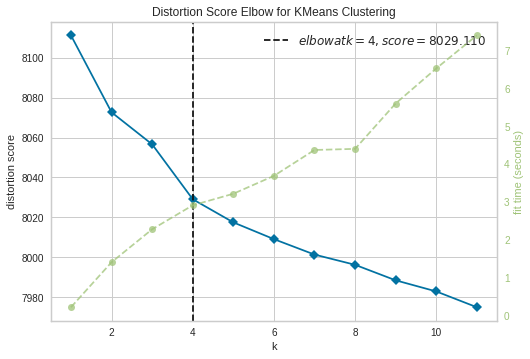

In [13]:
"""First cluster using KMeans and run the elbow visualizer to find the best number of clusters"""
modelKm = KMeans(random_state=12)
visualizer = KElbowVisualizer(modelKm, k=(1,12))

visualizer.fit(X)        # Fit the data to the visualizer
visualizer.show() 

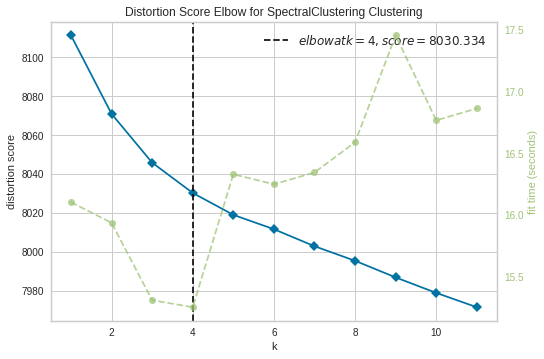

In [14]:
"""First cluster using Spectral and run the elbow visualizer to find the best number of clusters"""
modelSc = SpectralClustering(random_state=5)
visualizer = KElbowVisualizer(modelSc, k=(1,12))

visualizer.fit(X)        # Fit the data to the visualizer
visualizer.show() 

In [2]:
"""Train the Kmeans with the best n of clusters"""
modelKm = KMeans(n_clusters=4,random_state=12)
modelKm.fit(X)
y_kmeans = modelKm.predict(X)

"""Dimensionality reduction used to plot in 2d representation"""
pc=TruncatedSVD(n_components=2)
X_new=pc.fit_transform(X)
centr=pc.transform(modelKm.cluster_centers_)

print(centr)
plt.scatter(X_new[:,0],X_new[:,1],c=y_kmeans, cmap='viridis')
plt.scatter(centr[:,0],centr[:,1],marker='X',alpha=0.5,color='red',s=1000)

NameError: name 'X' is not defined

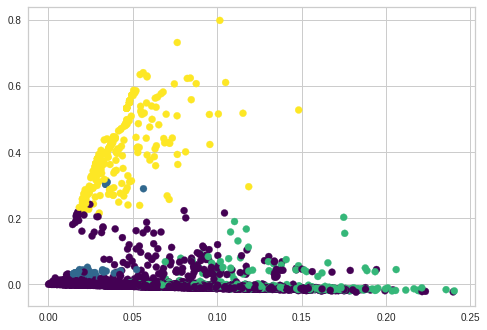

In [16]:
modelSc = SpectralClustering(n_clusters=4, random_state=5)
y_spc=modelSc.fit_predict(X)


pc=TruncatedSVD(n_components=2)
X_new=pc.fit_transform(X)

plt.scatter(X_new[:,0],X_new[:,1],c=y_spc, cmap='viridis')


### For both clustering algorithm the result seems similar from a graphical point of view. But let's inspect with wordcloud the most important words of each cluster.

In [17]:
#Rebuild the clusters in pandas df.

animes['ClusterKmeans']=y_kmeans
animes['ClusterSpectral']=y_spc
animes.head()

,title,description,Tokenized,Clean_text,Clean_text1,ClusterKmeans,ClusterSpectral
0,Fullmetal Alchemist: Brotherhood,The foundation of alchemy is based on the law ...,"[The, foundation, of, alchemy, is, based, on, ...","[foundation, alchemy, based, law, equivalent, ...",foundation alchemy based law equivalent exchan...,3,0
1,your name.,Mitsuha and Taki are two total strangers livin...,"[Mitsuha, and, Taki, are, two, total, stranger...","[mitsuha, taki, two, total, strangers, living,...",mitsuha taki two total strangers living comple...,3,0
2,A Silent Voice,"After transferring into a new school, a deaf g...","[After, transferring, into, a, new, school, ,,...","[transferring, new, school, deaf, girl, shouko...",transferring new school deaf girl shouko nishi...,2,2
3,Haikyuu!! Karasuno High School vs Shiratorizaw...,"Picking up where the second season ended, the ...","[Picking, up, where, the, second, season, ende...","[picking, second, season, ended, boys, prepare...",picking second season ended boys prepare final...,2,2
4,Attack on Titan 3rd Season: Part II,The battle to retake Wall Maria begins now! Wi...,"[The, battle, to, retake, Wall, Maria, begins,...","[battle, retake, wall, maria, begins, eren, ne...",battle retake wall maria begins eren new harde...,3,0


In [18]:
#Extract text based on cluster 
clus0_text=animes[animes['ClusterKmeans']==0]
clus1_text=animes[animes['ClusterKmeans']==1]
clus2_text=animes[animes['ClusterKmeans']==2]
clus3_text=animes[animes['ClusterKmeans']==3]

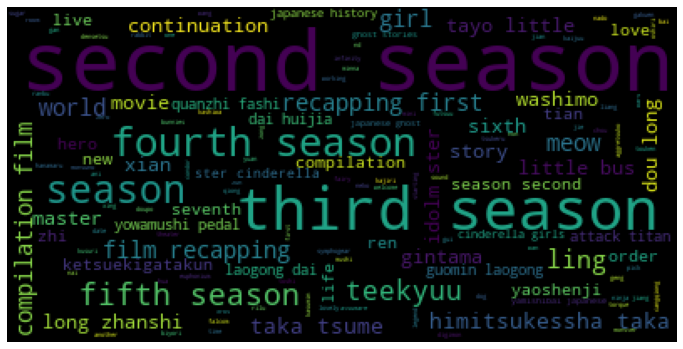

In [19]:
plt.figure(figsize=(12,8))
word_cloud = WordCloud(background_color='black',max_font_size = 80).generate(" ".join(clus0_text['Clean_text1']))
plt.imshow(word_cloud)
plt.axis('off')
plt.show()

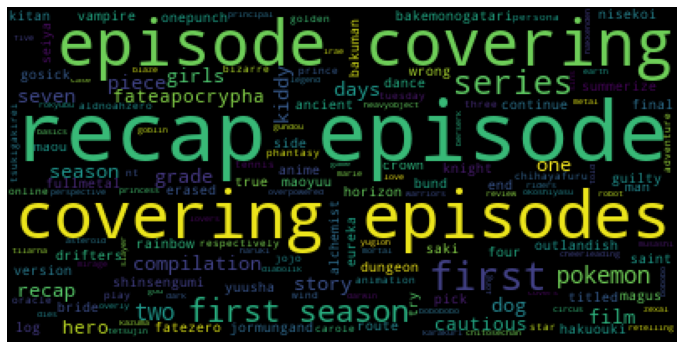

In [20]:
plt.figure(figsize=(12,8))
word_cloud = WordCloud(background_color='black',max_font_size = 80).generate(" ".join(clus1_text['Clean_text1']))
plt.imshow(word_cloud)
plt.axis('off')
plt.show()

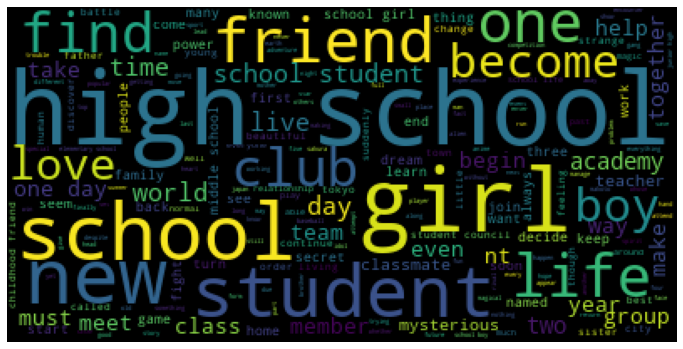

In [21]:
plt.figure(figsize=(12,8))
word_cloud = WordCloud(background_color='black',max_font_size = 80).generate(" ".join(clus2_text['Clean_text1']))
plt.imshow(word_cloud)
plt.axis('off')
plt.show()

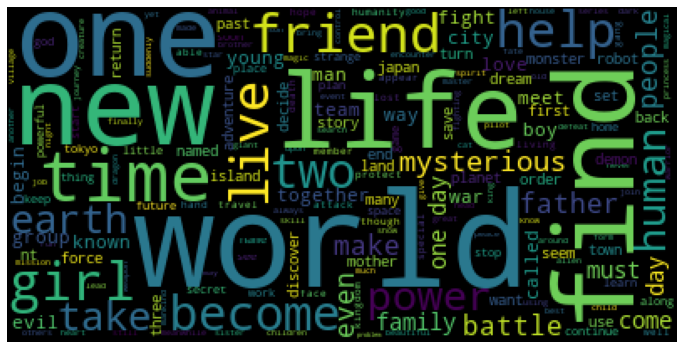

In [22]:
plt.figure(figsize=(12,8))
word_cloud = WordCloud(background_color='black',max_font_size = 80).generate(" ".join(clus3_text['Clean_text1']))
plt.imshow(word_cloud)
plt.axis('off')
plt.show()

### Inspecting the worldcloud view, is it possible to see that we have 4 clusters based on these words:
(The order of the clusters can be different)

* Cluster 1: Based on episodes, dungeon, recap episode, first season -> This cluster is kinda confusing me.
* Cluster 2: Clearly a cluster based on school anime. -> School anime.
* Cluster 3: Family, life, human, ... -> Thematics connected to this.
* Cluster 4: Based on season? -> Maybe it is a cluster where all the second,third,.. seasons are.

Let's see if with the spectral cluster we are more lucky.


In [23]:
#Extract text based on cluster 
clus0_text_sp=animes[animes['ClusterSpectral']==0]
clus1_text_sp=animes[animes['ClusterSpectral']==1]
clus2_text_sp=animes[animes['ClusterSpectral']==2]
clus3_text_sp=animes[animes['ClusterSpectral']==3]


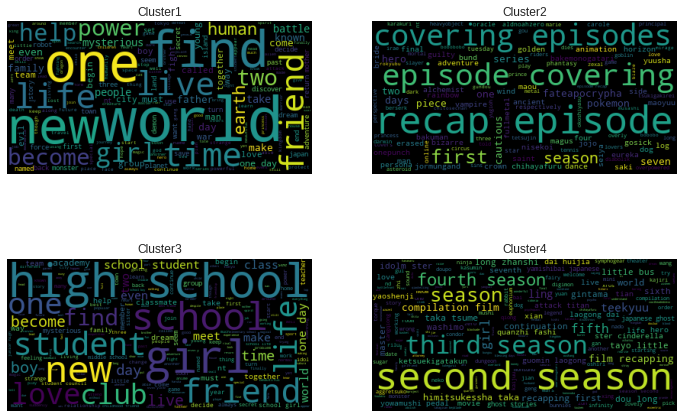

In [24]:
plt.figure(figsize=(12,8))
plt.subplot(221)
plt.title('Cluster1')
word_cloud = WordCloud(background_color='black',max_font_size = 80).generate(" ".join(clus0_text_sp['Clean_text1']))
plt.imshow(word_cloud)
plt.axis('off')

plt.subplot(222)
plt.title('Cluster2')
word_cloud = WordCloud(background_color='black',max_font_size = 80).generate(" ".join(clus1_text_sp['Clean_text1']))
plt.imshow(word_cloud)
plt.axis('off')

plt.subplot(223)
plt.title('Cluster3')
word_cloud = WordCloud(background_color='black',max_font_size = 80).generate(" ".join(clus2_text_sp['Clean_text1']))
plt.imshow(word_cloud)
plt.axis('off')

plt.subplot(224)
plt.title('Cluster4')
word_cloud = WordCloud(background_color='black',max_font_size = 80).generate(" ".join(clus3_text_sp['Clean_text1']))
plt.imshow(word_cloud)
plt.axis('off')


plt.show()

## With the spectral clustering more or less we found the same clusters:


## More or less the result of the two clustering algorithms is the same, based on the tf-idf value of the text contained in 'Description'.
